# Model Evaluation for Comparison

This notebook conducts the necessary model evaluation to compare the different model runs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Define input files
files = {
    "HaluEval_LLM": "../results/halueval_llm_results.csv",
    "HaluEval_Bedrock": "../results/halueval_bedrock_results.csv",
    "Challenger_LLM": "../results/synthetic_groundedness_challenger_set_llm_results.csv",
    "Challenger_Bedrock": "../results/synthetic_groundedness_challenger_set_bedrock_results.csv"
}

### Run evaluation metrics on model outputs

In [ ]:
# Step 1: Preprocess predictions
processed_files = {}

for name, path in files.items():
    df = pd.read_csv(path)
    if "llm" in name.lower():
        df.rename(columns={"llm_score": "prediction"}, inplace=True)
    else:
        df["prediction"] = df["bedrock_action"].apply(lambda x: "PASS" if x == "NONE" else "FAIL")
    
    processed_files[name] = df  


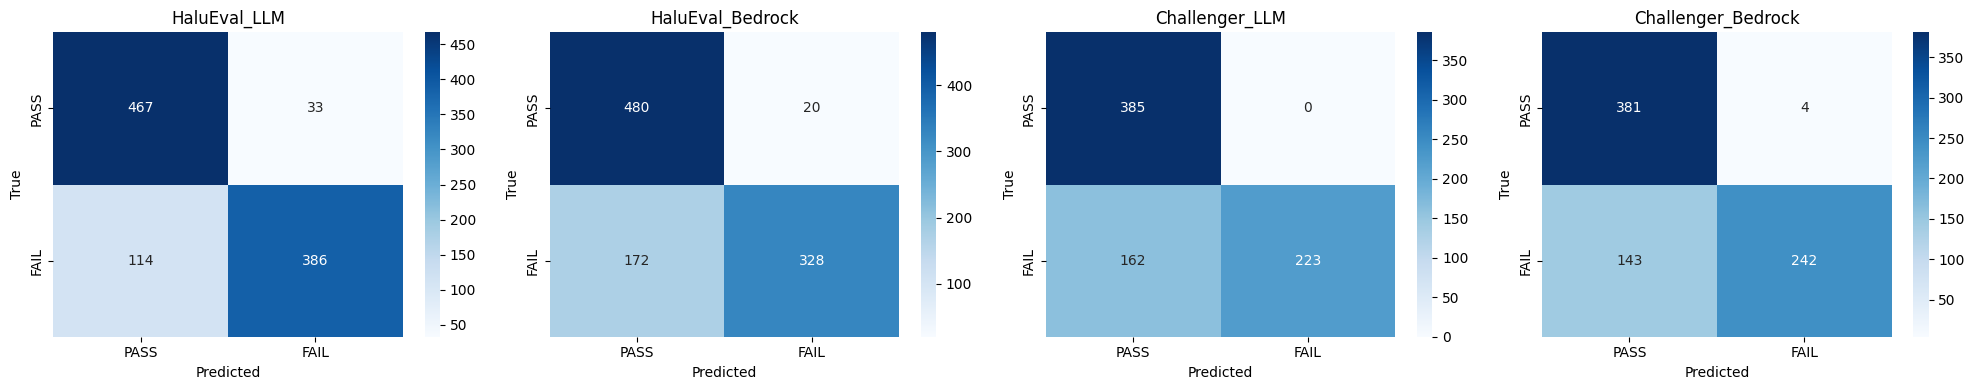

        Dataset_Model  Accuracy  Precision_PASS  Recall_PASS  F1_PASS  \
0        HaluEval_LLM      0.85            0.80         0.93     0.86   
1    HaluEval_Bedrock      0.81            0.74         0.96     0.83   
2      Challenger_LLM      0.79            0.70         1.00     0.83   
3  Challenger_Bedrock      0.81            0.73         0.99     0.84   

   Precision_FAIL  Recall_FAIL  F1_FAIL  Macro_Precision  Macro_Recall  \
0            0.92         0.77     0.84             0.86          0.85   
1            0.94         0.66     0.77             0.84          0.81   
2            1.00         0.58     0.73             0.85          0.79   
3            0.98         0.63     0.77             0.86          0.81   

   Macro_F1  
0      0.85  
1      0.80  
2      0.78  
3      0.80  


In [14]:
# Step 2: Evaluate and collect metrics
summary = []
confusion_matrices = {}

for name, df in processed_files.items():
    y_true = df["label"]
    y_pred = df["prediction"]

    cm = confusion_matrix(y_true, y_pred, labels=["PASS", "FAIL"])
    confusion_matrices[name] = cm

    report = classification_report(y_true, y_pred, output_dict=True, labels=["PASS", "FAIL"])
    
    summary.append({
    "Dataset_Model": name,
    "Accuracy": report["accuracy"],
    "Precision_PASS": report["PASS"]["precision"],
    "Recall_PASS": report["PASS"]["recall"],
    "F1_PASS": report["PASS"]["f1-score"],
    "Precision_FAIL": report["FAIL"]["precision"],
    "Recall_FAIL": report["FAIL"]["recall"],
    "F1_FAIL": report["FAIL"]["f1-score"],
    "Macro_Precision": report["macro avg"]["precision"],
    "Macro_Recall": report["macro avg"]["recall"],
    "Macro_F1": report["macro avg"]["f1-score"]
})


# Step 3: Plot all confusion matrices in one row
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(5 * len(confusion_matrices), 4))

for ax, (name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["PASS", "FAIL"], yticklabels=["PASS", "FAIL"], ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

# Step 4: Summary DataFrame
summary_df = pd.DataFrame(summary)
print(summary_df.round(2))

### Define an Off-the-Shelf Option using an AWS Bedrock Groundedness Guardrail

In [ ]:
# === Step 5: Prediction and Evaluation  ===
#df["llm_guardrail_pred"] = df["llm_score"].map(lambda x: 1 if str(x).upper() == "PASS" else 0)
#df["bedrock_pred"] = df["grounding_score"].apply(lambda x: 1 if x is not None and x >= 0.5 else 0)
#df["label"] = df["label"].astype(int)

#print("\n📊 Model Evaluation Summary:")
#for model_name in ["llm_guardrail_pred", "bedrock_pred"]:
#    print(f"\n🔍 {model_name}:\n")
#    print(classification_report(df["label"], df[model_name], target_names=["FAIL", "PASS"]))

# === Step 6: Save Results ===
results_path = "results/llm_bedrock_evaluation.csv"
df.to_csv(results_path, index=False)
print(f"\n✅ Evaluation complete. Results saved to '{results_path}'")